# Microscopy distributions and fold-change.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import scipy.ndimage
import pandas as pd
import mwc_induction_utils as mwc
mwc.set_plotting_style()
sns.set_context('talk')
%matplotlib notebook

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The purpose of this notebook is to generate the plots used for the supplementary figure `microscopy_flowchart.pdf`.

##  Fluorescence histograms

In [115]:
# Define the data directory
mic_data = pd.read_csv('../../data/RBS1027_O2_microscopy_cell_intensities.csv')
mic_data = mic_data[mic_data.date==20161019]
# Choose a subset of IPTG concentrations.
IPTG_range = [0, 10, 75,  250, 5000]

<IPython.core.display.Javascript object>


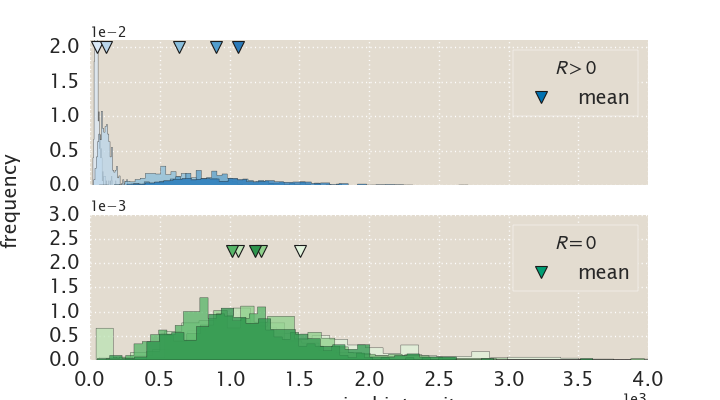

In [116]:
grouped = pd.groupby(mic_data, ['rbs', 'IPTG_uM'])
blues = sns.color_palette('Blues')
greens = sns.color_palette('Greens')
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9,5))
ax[0].plot([],[], 'v', markersize=10, markeredgewidth=1, markerfacecolor='b',
          markeredgecolor='k', label='mean')
ax[1].plot([],[], 'v', markersize=10, markeredgewidth=1, markerfacecolor='g',
          markeredgecolor='k', label='mean')
ax0_leg = ax[0].legend(loc='upper right', title='$R > 0$', fontsize=18)
ax1_leg = ax[1].legend(loc='upper right', title='$R = 0$', fontsize=18)
plt.setp(ax0_leg.get_title(),fontsize=18)
plt.setp(ax1_leg.get_title(),fontsize=18)

bi = 0
gi = 0
for group, data in grouped:
    if group[0] == 'RBS1027':
        if group[1] in IPTG_range:
            ax[0].hist(data.mean_intensity, bins=40, histtype='stepfilled',
                       color=blues[bi], normed=True, alpha=0.75)
            ax[0].plot(np.mean(data.mean_intensity), 0.02, 'v',
                       markeredgecolor='k', markersize=10, markerfacecolor=blues[bi],
                       markeredgewidth=1)
            bi += 1
            
    
    if group[0] == 'delta':
        if group[1] in IPTG_range:
            ax[1].hist(data.mean_intensity, bins=40, histtype='stepfilled',
                      color=greens[gi], normed=True, alpha=0.75)
            ax[1].plot(np.mean(data.mean_intensity), 0.00225, 'v',
                       markeredgecolor='k', markersize=10, markerfacecolor=greens[gi],
                       markeredgewidth=1)
            gi += 1
        
        
ax[0].set_ylim([0, 21E-3])
ax[1].set_ylim([0, 3E-3])
ax[1].set_xlabel('mean pixel intensity', fontsize=18)
fig.text(0.0, 0.5, 'frequency', va='center', rotation='vertical', fontsize=18)

for a in ax:
    a.ticklabel_format(style = 'sci', scilimits=(0, -3))
    a.tick_params(labelsize=18)
    a.set_xlim([0,4E3])

plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/microscopy_distributions.svg', bbox_inches='tight')

##  Fold-change calculation

In [117]:
grouped = pd.groupby(mic_data, ['IPTG_uM'])
fc = []
for group, data in grouped:
    auto = data[data.rbs=='auto'].mean_intensity.mean()
    delta = data[data.rbs=='delta'].mean_intensity.mean()
    samp = data[(data.rbs!='auto') & (data.rbs!='delta')].mean_intensity.mean()
    fc.append((samp - auto) / (delta - auto))

<IPython.core.display.Javascript object>


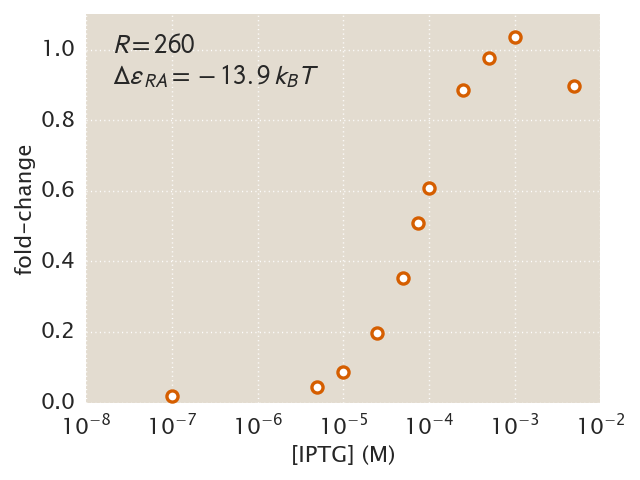

In [126]:
IPTG = mic_data.IPTG_uM.unique()/1E6
plt.figure(figsize=(8,6))
plt.plot(IPTG, fc, 'o', markersize=10, markeredgecolor='r', markerfacecolor='w', markeredgewidth=3)
ax = plt.gca()
plt.text(0.05, 0.9, '$R = 260$', fontsize=24,
        transform=ax.transAxes)
plt.text(0.05, 0.82, r'$\Delta\varepsilon_{RA} = -13.9\,k_BT$', fontsize=24,
        transform=ax.transAxes)
plt.xscale('log')
plt.tick_params(labelsize=20)
plt.xlabel('[IPTG] (M)', fontsize=20)
plt.ylabel('fold-change', fontsize=20)
plt.ylim([0, 1.1])
plt.xlim([1E-8, 1E-2])
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/example_microscopy_titration.svg', bbox_inches='tight')

In [86]:
IPTG
plt.tight_layout()

array([  0.00000000e+00,   1.00000000e-01,   5.00000000e+00,
         1.00000000e+01,   2.50000000e+01,   5.00000000e+01,
         7.50000000e+01,   1.00000000e+02,   2.50000000e+02,
         5.00000000e+02,   1.00000000e+03,   5.00000000e+03])